## ESP32<>nrfConnect<>Python


##### MPU_BLE_acc_x sketch







#### What to do with the odd hex data being received from the nrfLogger in text form? Kindly follow the below mentioned steps. 

The codes used here has been developed by Ravi Prakash with directional important inputs from Saksham Jain 


Installling libraries for the normal functioning of our program. In absence of any of the below library please uncomment and run the code or write the most updated version following the syntax.


In [441]:
#!pip3 install pyserial    
#!pip3 install numpy
#!pip3 install scipy
#!pip3 install matplotlib
#!pip3 install pyqtgraph 


Note: The above code install libraries for Python version >= 3.0. If by god's grace you find yourself using Python 2.0, please use "!pip" instead of "!pip3". 

!pip install pyserial // for Python version 2.x
!pip3 install pyserial // for Python version 3.x

Run the below code for importing the libraries

In [510]:
import serial
import numpy as np
import pandas as pd
import scipy.fftpack
import datetime as dt
import time
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import re
import datetime

Background: We receive the data from nrfConnect in text file format. Not all of it is the data that "we need" and some filtering has to be done. 

To save time and effort, this script can be used to :
- open a text file
- filter out the extact acceleration data(X,Y,Z) that we need in String format
- convert the data to int
- plot a beautiful graph given the gathered data is beautiful

In [511]:
f = open("Log_210227_3.txt", "r") #open a text file in "read only" mode
f1=f.read() #storing the file data into a variable as String

f2=f1.split("\n") #Splitting the data at every line 
f3=pd.DataFrame({"raw_data":f2,"index":0}) #Creating a DataFrame to store the split data into different lines 

f4=f3  # Just a  intermediary variable

#filters out the values which has "A" as an index in the first column
f5=f4.set_index('raw_data').filter(regex='^A', axis=0) 

f6=f4["raw_data"].str.split("\t", n = 2, expand = True) #Splitting raw data values in two at every space("\t")
f7 = f6[f6[0]=="A"] 
f8=pd.DataFrame(columns=["time","hex_data"]) 

f7

,0,1,2
30,A,03:50:23.395,"""Notifications enabled"" sent"
33,A,03:50:24.956,"""(0x) 2D-31-35-36-32-30, ""-15620"""" received"
35,A,03:50:26.932,"""(0x) 2D-31-35-36-34-30, ""-15640"""" received"
37,A,03:50:28.914,"""(0x) 2D-31-35-35-36-30, ""-15560"""" received"
39,A,03:50:30.938,"""(0x) 2D-31-35-36-30-38, ""-15608"""" received"
...,...,...,...
18883,A,04:01:42.095,"""(0x) 32-32-30, ""220"""" received"
18885,A,04:01:42.103,"""(0x) 31-39-32, ""192"""" received"
18887,A,04:01:42.110,"""(0x) 31-37-32, ""172"""" received"
18889,A,04:01:42.118,"""(0x) 31-34-34, ""144"""" received"


As you see, this data has lots of unwanted things and the index on the left is alternating numbers and it might even contain NAN [values. 
Time for additional processing. 

In [512]:
# Using regex to extraxt the data that we need. 
pattern = '\"(\-?\d\d+)'
regex=re.compile(pattern)
#applying the extraction to every row
f8["hex_data"]=f7[2].apply(lambda x: regex.findall(x))

#if want to extract time in date time format
#f8["time"] = f7[1].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S.%f').time()) 

f8["time"] = f7[1]
f9=f8
f9.dropna()

f9["hex_data"]= f9["hex_data"].apply(lambda x: pd.to_numeric(x))*5.9814*0.0001 #( dividing by 16384 and multiplying by 9.8)

f9["hex_data"]= f9["hex_data"] 


In [513]:
f9= f9[f9["hex_data"].astype(bool)]
#I don't know what this statement did but it worked. Looks like we are forcefully converting the "hex_data" column to bool 
# and every empty array would become FALSE and every array with numbers will be TRUE. Then it would create a new dataframe
# with the true values for the rows. 

In [514]:
f9.describe()

,time,hex_data
count,9347,9347
unique,8124,2699
top,04:00:50.572,[9.395583120000001]
freq,8,44


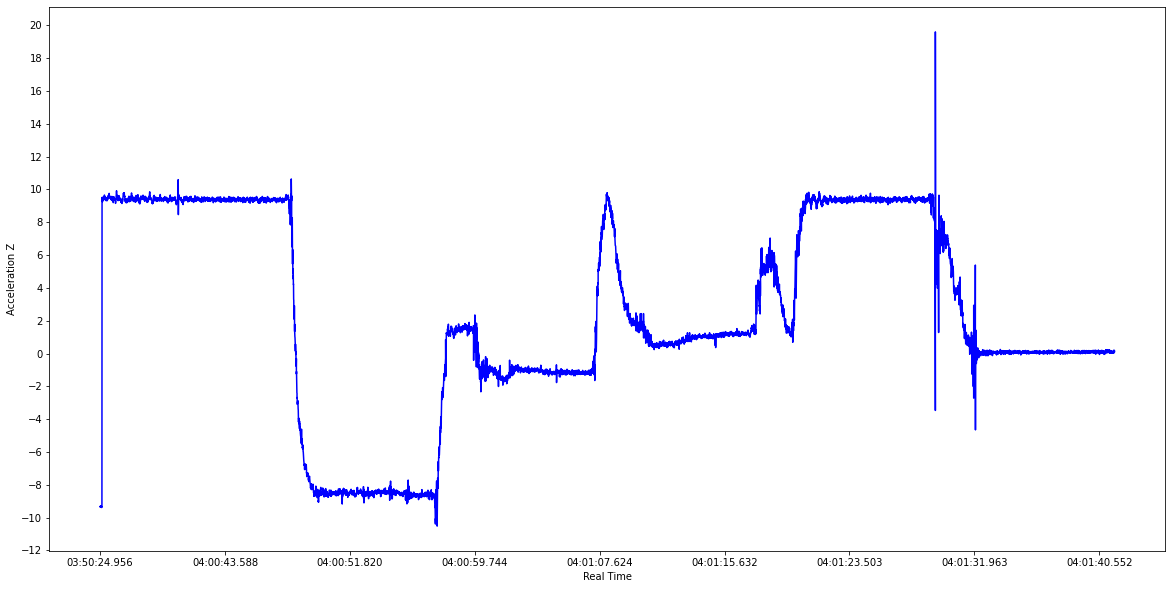

In [523]:
fig, ax = plt.subplots(1, 1,figsize=(20,10)) 

ax.plot(f9["time"], f9["hex_data"], '-b', label='AccZ') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 
plt.xlabel("Real Time")
plt.ylabel("Acceleration Z")
plt.show()

## Resource

In [473]:
#Converting the columns to integer from base 16 if the data is coming as hex
f10['Acc_X'] = f10['Acc_X'].apply(lambda x: int(x,16))
f10['Acc_Y'] = f10['Acc_Y'].apply(lambda x: int(x,16))
f10['Acc_Z'] = f10['Acc_Z'].apply(lambda x: int(x,16))

In [474]:
#find the first occurance of something in a column
f10["Index"].loc[f10['Acc_X'] == '" r'].argmax()

In [475]:
#Plot a graph
plt.plot(f10["time"], f10["Acc_Y"]) 

In [478]:
#Drop rows matching a particular column value
f10["Acc_X"]=f10.drop(f10[f10["Acc_X"] =='" r'].index, inplace = True)


In [ ]:
#f8["hex_data"] = f7[2].str.split("rece", n =1 , expand = True)
f8["hex_data"]=f7[2].str[5:35]  # In column no 2 (actually 3)
# 5:14 comes from our observation that the data starts at 5 and ends at 14 
# It ignores rest of the values

In [ ]:
#if want to extract time
f8["time"] = f7[1].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S.%f').time()) 